In [1]:
import numpy as np
import pandas as pd
import plotly 
import plotly.plotly as py
import matplotlib
import matplotlib.mlab as mlab
import seaborn as sns
import random
import time
import datetime
import matplotlib.pyplot as plt
import math

from datetime import *
from timeit import default_timer as timer

from matplotlib import pyplot as plt
from datetime import datetime
from scipy import stats
from plotly import figure_factory as FF
from scipy.linalg import svd, sqrtm, cholesky
from scipy.stats import multivariate_normal, normaltest, shapiro

from pandas.tools.plotting import scatter_matrix
from pandas import bdate_range
from pandas_datareader.data import DataReader
from pandas import Panel, DataFrame

import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from numpy.random import standard_normal

In [2]:
def Calc_stats(Prices, Val_date, Issue_date, N_coupons):
    hist_period = N_coupons - (Val_date-Issue_date).days/365.25  #смотрим назад на столько же, сколько осталось до последнего купона
    
    coupons_left = N_coupons - int(((Val_date-Issue_date).days/365))
    time_to_next_coupon = 1 - (Val_date-Issue_date).days/365 %1
    
    Prices_for_stats = (Prices[Prices.index>=Val_date -timedelta(days=hist_period*365.25)])
    Prices_for_stats = (Prices_for_stats[Prices_for_stats.index<Val_date])
    
    log_returns = np.log(Prices_for_stats/Prices_for_stats.shift(1)).dropna() 
    
    mu = log_returns.mean() #* 252
    sigma = log_returns.std() * np.sqrt(252)
    corr = log_returns.corr()
    K = Prices[Prices.index <= Issue_date+timedelta(days=1)]
    K = K[K.index >= Issue_date-timedelta(days=1)]
    S0 = Prices[Prices.index <= Val_date+timedelta(days=1)]
    S0 = S0[S0.index >= Val_date-timedelta(days=1)]
    
    return mu, sigma, corr, coupons_left, time_to_next_coupon, np.asarray(K), np.asarray(S0)


In [3]:
def price_on_date(Prices, Val_date, Issue_date, N_coupons , coupon):
    N_SIMS = 20000

    mu, sigma, corr, coupons_left, time_to_next_coupon,K,S0 = Calc_stats(Prices, Val_date, Issue_date, N_coupons)
    
    generated_values = pd.DataFrame(np.random.randn(3,coupons_left*N_SIMS))
    CHOL = cholesky(corr, lower=False)

    dW = generated_values.apply(lambda x: x.dot(CHOL))
    dW.index = sigma.index #*sigma
    dW = (dW.T*sigma)
    dW.iloc[range(0,len(dW),coupons_left)] = dW.iloc[range(0,len(dW),coupons_left)]*np.sqrt(time_to_next_coupon )

    for i in range(0, N_SIMS):
        dW.iloc[range(5*i,5*(i+1))] = dW.iloc[range(5*i,5*(i+1))].cumsum()

    dW.index = dW.index%coupons_left+time_to_next_coupon  #  индекс - это время в годах до каждого купона 

    S_t = S0[0]*np.exp(dW+np.outer((mu-sigma*sigma/2), dW.index).T)  # Наше ГБД в точках купонов    

    payoff = np.product((S_t>K[0]),axis = 1) # получаем индикаторы событий все базовые активы выше страйка

    payoff_with_mem =(np.zeros(payoff.shape))
              
    for s in range(0, N_SIMS): 
        for i in range(0, coupons_left):
            payoff_with_mem[s*coupons_left + i] = ((i+1) - payoff_with_mem[s*coupons_left :s*coupons_left +i].sum(axis = 0))*payoff[s*coupons_left +i]

    Discount = rfr[rfr.index <= Val_date].dropna()
    Discount = Discount.tail(1)/100
    
    Discount = (1+Discount.values)**(-np.asarray(S_t.index))
    npv = sum(sum(Discount*payoff_with_mem))/N_SIMS
    
    payoff_dist = []
    return npv*coupon 

In [4]:
start = datetime(2005, 7, 16)
Val_date = datetime(2016, 9, 17)
Issue_date = datetime(2016, 9, 15)

N_coupons = 5

MCD = DataReader("MCD", 'google', start, date.today())
DAL = DataReader("DAL", 'google', start, date.today())
DIS = DataReader("DIS", 'google', start, date.today())
rfr = DataReader("DGS5","fred",start, date.today())

Prices = pd.DataFrame()
Prices = Prices.assign(MCD = MCD['Close'], DAL = DAL['Close'], DIS = DIS['Close'])

In [6]:
df_market = pd.read_csv('data/market_13_03.csv', header=0, sep = ";")
df_market.Date = pd.to_datetime(df_market['Date'], format='%d.%m.%Y')

df_isin = pd.read_csv('data/market_all.csv', header=0, index_col=[0], sep = ";")
df_isin.index = pd.to_datetime(df_isin.index, format='%d.%m.%Y')

descr = pd.read_csv('data/descr.csv', header=0, index_col=[1], delimiter=';')
ISIN_NUM = 1
isin = descr.index[ISIN_NUM]
issuer = descr.Issuer[descr.index == isin].values[0]
coupon = descr.Coupon[descr.index == isin].values[0]
#df_price = pd.DataFrame(df_isin['ISIN'].dropna())
df_price = df_isin[df_isin['ISIN']==isin].dropna()['ASK']
df_price.columns = [issuer]
d0 = min(df_price.index)

print(isin, issuer, coupon, d0.date())

XS1514686911 Credit Suisse 0.03825 2016-12-22


In [7]:
daily_p = []
daily_d = []
start1 = timer()

for single_date in df_price.index:
    start = timer()
    pr = price_on_date(Prices,datetime.fromtimestamp((single_date).timestamp()),d0,5,coupon)
    
    daily_p.append(pr)
    daily_d.append(single_date)

df_mc = DataFrame(daily_p, index = daily_d, columns = ['model'])
print("Total time = ", timer()-start1, 'seconds')

Total time =  2419.0906942029833 seconds


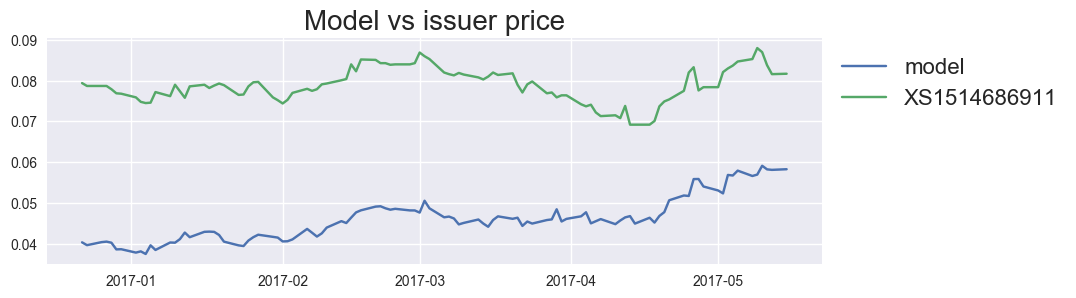

In [8]:
fig = plt.figure(num=None, figsize=(10, 3), dpi=100, facecolor='w', edgecolor='k')
plt.plot(daily_d,daily_p,label = 'model')
plt.plot(daily_d,df_price,label = isin)
plt.title('Model vs issuer price', size=20)
plt.legend(bbox_to_anchor=(1.0, 1.), loc=2,prop={'size':16})
plt.show()